In [39]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
import re
import time
import string
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm, notebook
import pickle
from joblib import dump
from sklearn.model_selection import train_test_split

from keras.layers import Dense, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization, Input
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn import datasets, svm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**load data**

In [ ]:
data_path = "/content/drive/MyDrive/PhoBert/clean_data.csv"
df = pd.read_csv(data_path)

In [ ]:
NUM_CLASSES = len(df['label'].unique())
index2class = {0:'NEG', 1:'POS'}
class2index = {"NEG": 0, "POS":1}

In [ ]:
df.label

0        POS
1        POS
2        NEG
3        POS
4        POS
        ... 
26737    NEG
26738    POS
26739    POS
26740    POS
26741    POS
Name: label, Length: 26742, dtype: object

In [ ]:
df.label = df.label.map(lambda x : class2index[x])

In [ ]:
df = df.dropna()
text = df.content.to_list()
label = df.label.to_list()

text_ = []
label_ = []

dict_count = {1 : 1, 0 : 1}

for i in range(len(text)):
    if dict_count[label[i]] <= 2500:
       text_.append(text[i])
       label_.append(label[i])
       dict_count[label[i]] += 1

In [ ]:
text = text_
label = label_

**pho_bert**

In [ ]:
def load_bert():
    v_phobert = AutoModel.from_pretrained("vinai/phobert-base")
    v_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
    return v_phobert, v_tokenizer
phobert, tokenizer = load_bert()

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def phobert_embed_sentence(padded, mask, model=phobert):
    # embed a single setence data
    # param padded: a tokenized, padded sentence
    # param mask: an attention mask of the padded sentence
    padded = torch.tensor(padded).to(torch.long)
    mask = torch.tensor(mask)
    with torch.no_grad():
        last_hidden_states = model(input_ids=padded, attention_mask=mask)[0]
    vector = last_hidden_states[:, 0, :].numpy() # [:,0,:] to get embedding vector of the first output token [CLS]
    return vector.flatten()

def phobert_embed_data(data, tokenizer=tokenizer):
    # embed the whole dataset with phobert
    # param padded_data: tokenized, padded dataset
    # param mask_data: attention masks of the padded dataset
    MAX_LENGTH = tokenizer.model_max_length # phobert default max sequence length = 256

    embedded_data = np.array([])
    for line in tqdm(data):
        tokenized_line = tokenizer.encode(line, max_length=MAX_LENGTH, truncation=True)
        # pad sentence to a pre-defined max length, no truncating since it is already truncated in the phobert tokenizing
        padded_line = pad_sequences([tokenized_line], maxlen=MAX_LENGTH, padding='post', value=1)
        # Get attention mask from padded sentence of data to make PhoBERT focus on non-padded data only
        # pad tokenized sentence with value = 1, since 1 is pre-defined padding value of PhoBERT
        mask = np.where(padded_line == 1, 0, 1)

        embedded_line = phobert_embed_sentence(padded_line, mask)
        
        if embedded_data.shape[0] == 0:
            embedded_data = np.empty((0, embedded_line.shape[0]), 'float32')
            
        embedded_data = np.concatenate((embedded_data, [embedded_line]))
    return embedded_data

In [38]:
phobert_train = phobert_embed_data(text)

100%|██████████| 5000/5000 [1:06:28<00:00,  1.25it/s]


In [40]:
np.savetxt('/content/drive/MyDrive/PhoBert/PhoBertEmbedding.txt', phobert_train)

In [59]:
dump(label,'/content/drive/MyDrive/PhoBert/label.pkl')

['/content/drive/MyDrive/PhoBert/label.pkl']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(phobert_train, label, test_size=0.1, random_state=0)

In [53]:
cl = svm.SVC(kernel='linear', probability=True, gamma=0.125)
cl.fit(X_train,y_train)

SVC(gamma=0.125, kernel='linear', probability=True)

In [56]:
cl.score(X_train,y_train)

0.9437777777777778

In [58]:
cl.score(X_test,y_test)

0.876

**LSTM**

In [64]:
y_train = pd.get_dummies(y_train)
X_train = np.expand_dims(X_train,axis = 1)

In [67]:
MAX_EPOCHS = 200

checkpoint_path = "/content/drive/MyDrive/PhoBert/"

model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences = True,input_shape = (1,768)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(128,return_sequences = False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(2,activation='softmax')  
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=50,
                                                  mode='min',
                                                  restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'LSTM', monitor='val_loss', save_best_only=True, save_feq='epoch')
model_LSTM.compile(optimizer='adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [68]:
history = model_LSTM.fit(np.array(X_train),np.array(y_train),validation_split=0.2, epochs=200,batch_size = 32, callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
112/113 [============================>.] - ETA: 0s - loss: 0.4589 - accuracy: 0.7773

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


113/113 [==============================] - 24s 122ms/step - loss: 0.4574 - accuracy: 0.7783 - val_loss: 0.3442 - val_accuracy: 0.8456
Epoch 2/200
110/113 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8616

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


113/113 [==============================] - 13s 117ms/step - loss: 0.3274 - accuracy: 0.8619 - val_loss: 0.3170 - val_accuracy: 0.8611
Epoch 3/200
106/113 [===========================>..] - ETA: 0s - loss: 0.2884 - accuracy: 0.8830

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


113/113 [==============================] - 13s 119ms/step - loss: 0.2928 - accuracy: 0.8817 - val_loss: 0.3097 - val_accuracy: 0.8578
Epoch 4/200
113/113 [==============================] - 1s 8ms/step - loss: 0.2676 - accuracy: 0.8947 - val_loss: 0.3314 - val_accuracy: 0.8644
Epoch 5/200
113/113 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9033

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/LSTM/assets


113/113 [==============================] - 14s 128ms/step - loss: 0.2450 - accuracy: 0.9033 - val_loss: 0.3027 - val_accuracy: 0.8667
Epoch 6/200
113/113 [==============================] - 1s 7ms/step - loss: 0.2260 - accuracy: 0.9122 - val_loss: 0.3292 - val_accuracy: 0.8622
Epoch 7/200
113/113 [==============================] - 1s 6ms/step - loss: 0.2032 - accuracy: 0.9275 - val_loss: 0.3230 - val_accuracy: 0.8644
Epoch 8/200
113/113 [==============================] - 1s 6ms/step - loss: 0.1809 - accuracy: 0.9319 - val_loss: 0.3290 - val_accuracy: 0.8633
Epoch 9/200
113/113 [==============================] - 1s 6ms/step - loss: 0.1626 - accuracy: 0.9436 - val_loss: 0.3548 - val_accuracy: 0.8678
Epoch 10/200
113/113 [==============================] - 1s 6ms/step - loss: 0.1405 - accuracy: 0.9475 - val_loss: 0.3974 - val_accuracy: 0.8700
Epoch 11/200
113/113 [==============================] - 1s 7ms/step - loss: 0.1356 - accuracy: 0.9503 - val_loss: 0.4095 - val_accuracy: 0.8556
Epoch 

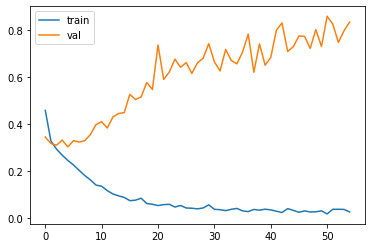

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

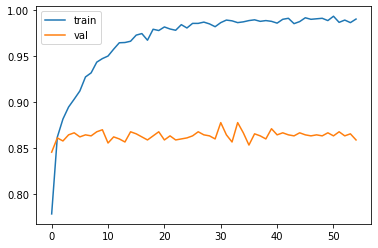

In [72]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

In [81]:
model_LSTM.evaluate(np.array(np.expand_dims(X_test,1)),np.array(pd.get_dummies(y_test)))

16/16 [==============================] - 0s 5ms/step - loss: 0.3021 - accuracy: 0.8740


[0.302094429731369, 0.8740000128746033]

**CNN**

In [95]:
X_train, X_test, y_train, y_test = train_test_split(phobert_train, label, test_size=0.1, random_state=0)

In [96]:
X_train = np.expand_dims(X_train,-1)

In [111]:
CNN_model = tf.keras.models.Sequential([
              Conv1D(128, kernel_size=5, input_shape=(768,1)),
              Conv1D(64, kernel_size=3, activation='relu'),
              GlobalMaxPooling1D(),
              Dense(32, activation='relu'),
              Dense(2, activation='softmax')                            
            ])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'CNN', monitor='val_loss', save_best_only=True, save_feq='epoch')
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_CNN = CNN_model.fit(np.array(X_train),np.array(y_train), epochs=100, verbose=1, validation_split=0.2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
106/113 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5534INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 15ms/step - loss: 0.6791 - accuracy: 0.5558 - val_loss: 0.6574 - val_accuracy: 0.5833
Epoch 2/100
104/113 [==========================>...] - ETA: 0s - loss: 0.6461 - accuracy: 0.6220INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 1s 13ms/step - loss: 0.6433 - accuracy: 0.6256 - val_loss: 0.6234 - val_accuracy: 0.6678
Epoch 3/100
111/113 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.6641INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 1s 13ms/step - loss: 0.6124 - accuracy: 0.6647 - val_loss: 0.5957 - val_accuracy: 0.6900
Epoch 4/100
104/113 [==========================>...] - ETA: 0s - loss: 0.5957 - accuracy: 0.6776INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 1s 13ms/step - loss: 0.5973 - accuracy: 0.6758 - val_loss: 0.5896 - val_accuracy: 0.6811
Epoch 5/100
109/113 [===========================>..] - ETA: 0s - loss: 0.5746 - accuracy: 0.7021INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 1s 13ms/step - loss: 0.5757 - accuracy: 0.7017 - val_loss: 0.5735 - val_accuracy: 0.7200
Epoch 6/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5670 - accuracy: 0.7039 - val_loss: 0.5852 - val_accuracy: 0.6822
Epoch 7/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5624 - accuracy: 0.7033 - val_loss: 0.6305 - val_accuracy: 0.6222
Epoch 8/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5577 - accuracy: 0.7053 - val_loss: 0.6101 - val_accuracy: 0.6489
Epoch 9/100
110/113 [============================>.] - ETA: 0s - loss: 0.5503 - accuracy: 0.7170INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 1s 13ms/step - loss: 0.5493 - accuracy: 0.7169 - val_loss: 0.5725 - val_accuracy: 0.6989
Epoch 10/100
107/113 [===========================>..] - ETA: 0s - loss: 0.5390 - accuracy: 0.7325INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 1s 13ms/step - loss: 0.5383 - accuracy: 0.7328 - val_loss: 0.5621 - val_accuracy: 0.7111
Epoch 11/100
104/113 [==========================>...] - ETA: 0s - loss: 0.5442 - accuracy: 0.7245INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 20s 179ms/step - loss: 0.5439 - accuracy: 0.7242 - val_loss: 0.5553 - val_accuracy: 0.7344
Epoch 12/100
113/113 [==============================] - 1s 8ms/step - loss: 0.5359 - accuracy: 0.7286 - val_loss: 0.5571 - val_accuracy: 0.7244
Epoch 13/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5256 - accuracy: 0.7439 - val_loss: 0.5672 - val_accuracy: 0.7211
Epoch 14/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5313 - accuracy: 0.7394 - val_loss: 0.5722 - val_accuracy: 0.6956
Epoch 15/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5248 - accuracy: 0.7328 - val_loss: 0.5830 - val_accuracy: 0.6867
Epoch 16/100
109/113 [===========================>..] - ETA: 0s - loss: 0.5224 - accuracy: 0.7466INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 14ms/step - loss: 0.5222 - accuracy: 0.7467 - val_loss: 0.5534 - val_accuracy: 0.7333
Epoch 17/100
105/113 [==========================>...] - ETA: 0s - loss: 0.5011 - accuracy: 0.7589INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 14ms/step - loss: 0.5031 - accuracy: 0.7594 - val_loss: 0.5529 - val_accuracy: 0.7244
Epoch 18/100
109/113 [===========================>..] - ETA: 0s - loss: 0.5175 - accuracy: 0.7474INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 14ms/step - loss: 0.5151 - accuracy: 0.7486 - val_loss: 0.5478 - val_accuracy: 0.7400
Epoch 19/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5213 - accuracy: 0.7422 - val_loss: 0.5509 - val_accuracy: 0.7433
Epoch 20/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5123 - accuracy: 0.7531 - val_loss: 0.5510 - val_accuracy: 0.7411
Epoch 21/100
106/113 [===========================>..] - ETA: 0s - loss: 0.5073 - accuracy: 0.7535INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 14ms/step - loss: 0.5067 - accuracy: 0.7528 - val_loss: 0.5470 - val_accuracy: 0.7244
Epoch 22/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5126 - accuracy: 0.7547 - val_loss: 0.6047 - val_accuracy: 0.6589
Epoch 23/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5015 - accuracy: 0.7669 - val_loss: 0.5500 - val_accuracy: 0.7178
Epoch 24/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5011 - accuracy: 0.7603 - val_loss: 0.5531 - val_accuracy: 0.7433
Epoch 25/100
108/113 [===========================>..] - ETA: 0s - loss: 0.4934 - accuracy: 0.7656INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 13ms/step - loss: 0.4945 - accuracy: 0.7636 - val_loss: 0.5460 - val_accuracy: 0.7378
Epoch 26/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4916 - accuracy: 0.7653 - val_loss: 0.5471 - val_accuracy: 0.7467
Epoch 27/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5073 - accuracy: 0.7561 - val_loss: 0.5561 - val_accuracy: 0.7433
Epoch 28/100
112/113 [============================>.] - ETA: 0s - loss: 0.4897 - accuracy: 0.7670INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 21ms/step - loss: 0.4900 - accuracy: 0.7669 - val_loss: 0.5447 - val_accuracy: 0.7433
Epoch 29/100
107/113 [===========================>..] - ETA: 0s - loss: 0.4978 - accuracy: 0.7591INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/CNN/assets


113/113 [==============================] - 2s 14ms/step - loss: 0.4951 - accuracy: 0.7619 - val_loss: 0.5408 - val_accuracy: 0.7267
Epoch 30/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4962 - accuracy: 0.7658 - val_loss: 0.5579 - val_accuracy: 0.7322
Epoch 31/100
113/113 [==============================] - 1s 7ms/step - loss: 0.5014 - accuracy: 0.7564 - val_loss: 0.5430 - val_accuracy: 0.7467
Epoch 32/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4856 - accuracy: 0.7728 - val_loss: 0.5510 - val_accuracy: 0.7400
Epoch 33/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4808 - accuracy: 0.7756 - val_loss: 0.5431 - val_accuracy: 0.7378
Epoch 34/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4881 - accuracy: 0.7672 - val_loss: 0.6167 - val_accuracy: 0.7056
Epoch 35/100
113/113 [==============================] - 1s 7ms/step - loss: 0.4927 - accuracy: 0.7633 - val_loss: 0.5546 - val_accuracy: 0.7167
Epoc

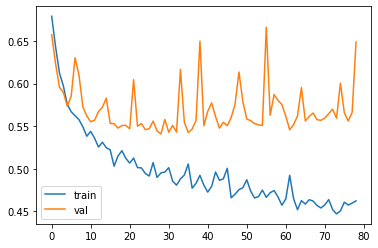

In [112]:
plt.plot(history_CNN.history['loss'], label='train')
plt.plot(history_CNN.history['val_loss'], label='val')
plt.legend()

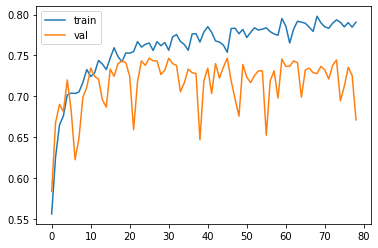

In [113]:
plt.plot(history_CNN.history['accuracy'], label='train')
plt.plot(history_CNN.history['val_accuracy'], label='val')
plt.legend()

In [115]:
CNN_model.evaluate(np.array(np.expand_dims(X_test,-1)),np.array(y_test))

16/16 [==============================] - 0s 8ms/step - loss: 0.5620 - accuracy: 0.7040


[0.5619721412658691, 0.7039999961853027]

**MLP**

In [102]:
MLP_MODEL = Sequential()
MLP_MODEL.add(Input(768,1))
MLP_MODEL.add(Dense(200, activation='relu'))
MLP_MODEL.add(Dense(100, activation='relu'))
MLP_MODEL.add(Dense(20, activation='relu'))
MLP_MODEL.add(Dense(2, activation='softmax'))

In [104]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'MLP', monitor='val_loss', save_best_only=True, save_feq='epoch')
MLP_MODEL.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_MLP = MLP_MODEL.fit(np.array(X_train),np.array(y_train), epochs=200, verbose=1, validation_split=0.2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
110/113 [============================>.] - ETA: 0s - loss: 8.2431 - accuracy: 0.9000INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/MLP/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/MLP/assets


113/113 [==============================] - 41s 364ms/step - loss: 8.2508 - accuracy: 0.8994 - val_loss: 9.9019 - val_accuracy: 0.8678
Epoch 2/200
113/113 [==============================] - 0s 3ms/step - loss: 6.4871 - accuracy: 0.9239 - val_loss: 10.7563 - val_accuracy: 0.8556
Epoch 3/200
113/113 [==============================] - 0s 3ms/step - loss: 5.2176 - accuracy: 0.9425 - val_loss: 12.3130 - val_accuracy: 0.8622
Epoch 4/200
113/113 [==============================] - 0s 3ms/step - loss: 3.9528 - accuracy: 0.9594 - val_loss: 11.6557 - val_accuracy: 0.8678
Epoch 5/200
113/113 [==============================] - 0s 3ms/step - loss: 3.1183 - accuracy: 0.9700 - val_loss: 12.8277 - val_accuracy: 0.8656
Epoch 6/200
113/113 [==============================] - 0s 3ms/step - loss: 2.9110 - accuracy: 0.9717 - val_loss: 14.7359 - val_accuracy: 0.8589
Epoch 7/200
113/113 [==============================] - 0s 3ms/step - loss: 2.3649 - accuracy: 0.9778 - val_loss: 15.7564 - val_accuracy: 0.8489
Ep

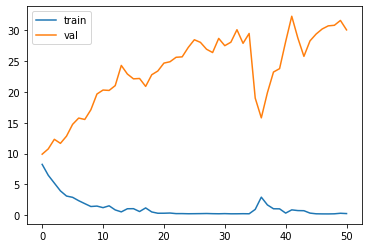

In [105]:
plt.plot(history_MLP.history['loss'], label='train')
plt.plot(history_MLP.history['val_loss'], label='val')
plt.legend()

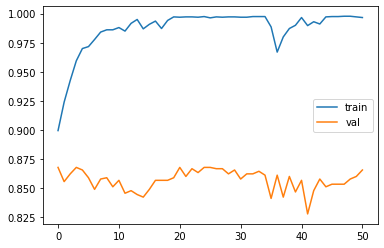

In [106]:
plt.plot(history_MLP.history['accuracy'], label='train')
plt.plot(history_MLP.history['val_accuracy'], label='val')
plt.legend()

In [116]:
MLP_MODEL.evaluate(np.array(np.expand_dims(X_test,-1)),np.array(y_test))

16/16 [==============================] - 0s 4ms/step - loss: 9.3558 - accuracy: 0.8900


[9.355782508850098, 0.8899999856948853]

**BiLSTM**

In [117]:
X_train, X_test, y_train, y_test = train_test_split(phobert_train, label, test_size=0.1, random_state=0)

In [ ]:
multi_bilstm_model = tf.keras.Sequential([
    Bidirectional(tf.keras.layers.LSTM(128,return_sequences = True,input_shape = (1,768))),
    tf.keras.layers.Dropout(0.5),
    Bidirectional(tf.keras.layers.LSTM(128,return_sequences = False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(2,activation='softmax')  
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'BiLSTM', monitor='val_loss', save_best_only=True, save_feq='epoch')
multi_bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_biLSTM = multi_bilstm_model.fit(np.array(np.expand_dims(X_train,-1)),np.array(y_train), epochs=200, verbose=1, validation_split=0.2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
113/113 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.5561

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 50s 353ms/step - loss: 0.6820 - accuracy: 0.5561 - val_loss: 0.6643 - val_accuracy: 0.6167
Epoch 2/200
113/113 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.5867

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 40s 352ms/step - loss: 0.6642 - accuracy: 0.5867 - val_loss: 0.6596 - val_accuracy: 0.6256
Epoch 3/200
113/113 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.5964

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 42s 375ms/step - loss: 0.6607 - accuracy: 0.5964 - val_loss: 0.6446 - val_accuracy: 0.6244
Epoch 4/200
113/113 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.6031

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 54s 484ms/step - loss: 0.6554 - accuracy: 0.6031 - val_loss: 0.6391 - val_accuracy: 0.6467
Epoch 5/200
113/113 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.6244

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 38s 334ms/step - loss: 0.6424 - accuracy: 0.6244 - val_loss: 0.6209 - val_accuracy: 0.6389
Epoch 6/200
113/113 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.6386

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 39s 343ms/step - loss: 0.6278 - accuracy: 0.6386 - val_loss: 0.5966 - val_accuracy: 0.6789
Epoch 7/200
113/113 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6594

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 38s 333ms/step - loss: 0.6147 - accuracy: 0.6594 - val_loss: 0.5933 - val_accuracy: 0.6844
Epoch 8/200
113/113 [==============================] - 17s 154ms/step - loss: 0.6371 - accuracy: 0.6303 - val_loss: 0.6220 - val_accuracy: 0.6578
Epoch 9/200
113/113 [==============================] - 17s 151ms/step - loss: 0.6370 - accuracy: 0.6214 - val_loss: 0.6403 - val_accuracy: 0.5956
Epoch 10/200
113/113 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.6500

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 331ms/step - loss: 0.6154 - accuracy: 0.6500 - val_loss: 0.5931 - val_accuracy: 0.6778
Epoch 11/200
113/113 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6583

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 38s 333ms/step - loss: 0.6124 - accuracy: 0.6583 - val_loss: 0.5892 - val_accuracy: 0.6822
Epoch 12/200
113/113 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.6639

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 38s 336ms/step - loss: 0.6059 - accuracy: 0.6639 - val_loss: 0.5740 - val_accuracy: 0.6944
Epoch 13/200
113/113 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6628

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 331ms/step - loss: 0.6084 - accuracy: 0.6628 - val_loss: 0.5649 - val_accuracy: 0.7200
Epoch 14/200
113/113 [==============================] - 16s 145ms/step - loss: 0.5943 - accuracy: 0.6753 - val_loss: 0.5742 - val_accuracy: 0.6933
Epoch 15/200
113/113 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.6825

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 39s 343ms/step - loss: 0.5895 - accuracy: 0.6825 - val_loss: 0.5642 - val_accuracy: 0.7156
Epoch 16/200
113/113 [==============================] - 16s 145ms/step - loss: 0.5836 - accuracy: 0.6911 - val_loss: 0.6039 - val_accuracy: 0.6933
Epoch 17/200
113/113 [==============================] - 16s 144ms/step - loss: 0.5877 - accuracy: 0.6875 - val_loss: 0.5673 - val_accuracy: 0.7067
Epoch 18/200
113/113 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.6956

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 333ms/step - loss: 0.5727 - accuracy: 0.6956 - val_loss: 0.5451 - val_accuracy: 0.7233
Epoch 19/200
113/113 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7003

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 330ms/step - loss: 0.5704 - accuracy: 0.7003 - val_loss: 0.5373 - val_accuracy: 0.7200
Epoch 20/200
113/113 [==============================] - 16s 144ms/step - loss: 0.5676 - accuracy: 0.7003 - val_loss: 0.5536 - val_accuracy: 0.6989
Epoch 21/200
113/113 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7119

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 332ms/step - loss: 0.5559 - accuracy: 0.7119 - val_loss: 0.5340 - val_accuracy: 0.7144
Epoch 22/200
113/113 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.7139

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 331ms/step - loss: 0.5508 - accuracy: 0.7139 - val_loss: 0.5264 - val_accuracy: 0.7300
Epoch 23/200
113/113 [==============================] - 16s 144ms/step - loss: 0.5440 - accuracy: 0.7197 - val_loss: 0.5305 - val_accuracy: 0.7256
Epoch 24/200
113/113 [==============================] - 17s 154ms/step - loss: 0.5406 - accuracy: 0.7275 - val_loss: 0.5278 - val_accuracy: 0.7189
Epoch 25/200
113/113 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.7369

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 331ms/step - loss: 0.5234 - accuracy: 0.7369 - val_loss: 0.5220 - val_accuracy: 0.7289
Epoch 26/200
113/113 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7358

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 45s 397ms/step - loss: 0.5311 - accuracy: 0.7358 - val_loss: 0.5092 - val_accuracy: 0.7444
Epoch 27/200
113/113 [==============================] - 27s 235ms/step - loss: 0.5160 - accuracy: 0.7519 - val_loss: 0.5224 - val_accuracy: 0.7356
Epoch 28/200
113/113 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7489

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 50s 445ms/step - loss: 0.5103 - accuracy: 0.7489 - val_loss: 0.5078 - val_accuracy: 0.7367
Epoch 29/200
113/113 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.7592

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 37s 331ms/step - loss: 0.4957 - accuracy: 0.7592 - val_loss: 0.5021 - val_accuracy: 0.7456
Epoch 30/200
113/113 [==============================] - 16s 145ms/step - loss: 0.4965 - accuracy: 0.7606 - val_loss: 0.5057 - val_accuracy: 0.7567
Epoch 31/200
113/113 [==============================] - 17s 155ms/step - loss: 0.4985 - accuracy: 0.7547 - val_loss: 0.5353 - val_accuracy: 0.7356
Epoch 32/200
113/113 [==============================] - 17s 153ms/step - loss: 0.4823 - accuracy: 0.7644 - val_loss: 0.5152 - val_accuracy: 0.7378
Epoch 33/200
113/113 [==============================] - 16s 144ms/step - loss: 0.4746 - accuracy: 0.7794 - val_loss: 0.5212 - val_accuracy: 0.7244
Epoch 34/200
113/113 [==============================] - 16s 144ms/step - loss: 0.4736 - accuracy: 0.7761 - val_loss: 0.5129 - val_accuracy: 0.7589
Epoch 35/200
113/113 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7739

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PhoBert/BiLSTM/assets


113/113 [==============================] - 39s 343ms/step - loss: 0.4658 - accuracy: 0.7739 - val_loss: 0.5007 - val_accuracy: 0.7289
Epoch 36/200
113/113 [==============================] - 16s 145ms/step - loss: 0.4600 - accuracy: 0.7856 - val_loss: 0.5068 - val_accuracy: 0.7589
Epoch 37/200
113/113 [==============================] - 16s 144ms/step - loss: 0.4496 - accuracy: 0.7947 - val_loss: 0.5117 - val_accuracy: 0.7456
Epoch 38/200
113/113 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.7983

In [ ]:
plt.plot(history_biLSTM.history['loss'], label='train')
plt.plot(history_biLSTM.history['val_loss'], label='val')
plt.legend()

In [ ]:
plt.plot(history_biLSTM.history['accuracy'], label='train')
plt.plot(history_biLSTM.history['val_accuracy'], label='val')
plt.legend()

In [ ]:
multi_bilstm_model.evaluate(np.array(np.expand_dims(X_test,1)),np.array(y_test))